<h1><center>
    ECE 438 - Laboratory 9b<br/>
    Speech Processing (Week 2)<br/>
    <small>Last Updated on April 5, 2022</small><br/>
    <br/>
    Date:<br/>
    Section:<br/>
</center></h1>

|Name |Signature |Time spent outside lab|
|:---:|:---:|:---:|
|Student Name #1 [---%]| | |
|Student Name #2 [---%]| | |

||Below expectations| Lacks in some respect|Meets all expectations|
|:---:|:---:|:---:|:---:|
|**Completeness of the report**||||
|**Organization of the report**||||
|**Quality of figures**: *Correctly labeled with title, x-axis, y-axis, and name(s)*||||
|**Understanding of linear predictive coding (55 pts)**: *Synthesis of voiced speech: Python plots, questions, Coefficient computation: Python code (`mylpc`)*||||
|**Understanding of speech coding and synthesis (45 pts)**: *Python plots and code, questions*||||

In [159]:
import sys
import json
import numpy as np
import scipy as scp
import scipy.signal
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

In [160]:
# make sure the plot is displayed in this notebook
%matplotlib inline
# specify the size of the plot
plt.rcParams['figure.figsize'] = (16, 6)

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h3 style="color:red;"><left>Exercise 1.2: Synthesis of Voiced Speech</left></h3>

**1. Use the following code to load three sets of filter coefficients: ```A1```, ```A2```, and ```A3```, respectively, for the vocal tract model in equations (1) and (2). Each vector contains coefficients $\{a_1,a_2,\dots,a_{15}\}$ for an all-pole filter of order $15$.**

In [161]:
coeff = json.load(open("coeff.json", 'r'))
A1 = np.array(coeff["A1"])
A2 = np.array(coeff["A2"])
A3 = np.array(coeff["A3"])

**2. Complete the function below to create a length `N` excitation for voiced speech, with a pitch period of `Np` samples. The output vector ```x``` should contain a discrete-time impulse train with period ```Np``` (e.g., $[1,0,0,\cdots,0,1,0,0,\cdots]$).**

In [162]:
def exciteV(N, Np):
    """
    Parameters
    ---
    N: the length of excitation
    Np: pitch period in number of samples
    
    Returns
    ---
    x: a discrete-time impulse train with period Np
    """
    x = []
    for i in range(N):
      if ((i+Np) % Np) == 0:
        x.append(1)
      else:
        x.append(0)
    return x

**3. Assuming a sampling frequency of $8$ kHz ($0.125$ ms/sample), create a $40$ millisecond-long excitation with a pitch period of $8$ ms, and filter it using equation (2) for each set of coefficients.**

**You may use the command:**
```python
s = scp.signal.lfilter(np.array([1]), np.insert(-A, 0, 1), x)
```
**where ```A``` is the row vector of filter coefficients.**

**[```scp.signal.lfilter()```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) filter data along one-dimension with an IIR or FIR filter**.

**[```np.insert(arr, 0, 1)```](https://numpy.org/doc/stable/reference/generated/numpy.insert.html) insert the value 1 at the beginning of ```arr```.**

In [163]:
# insert your code here
x = exciteV(int(40/0.125), int(8/0.125))
s1 = scp.signal.lfilter(np.array([1]), np.insert(-A1, 0, 1), x)
s2 = scp.signal.lfilter(np.array([1]), np.insert(-A2, 0, 1), x)
s3 = scp.signal.lfilter(np.array([1]), np.insert(-A3, 0, 1), x)


**4. Plot each of the three filtered signals.**

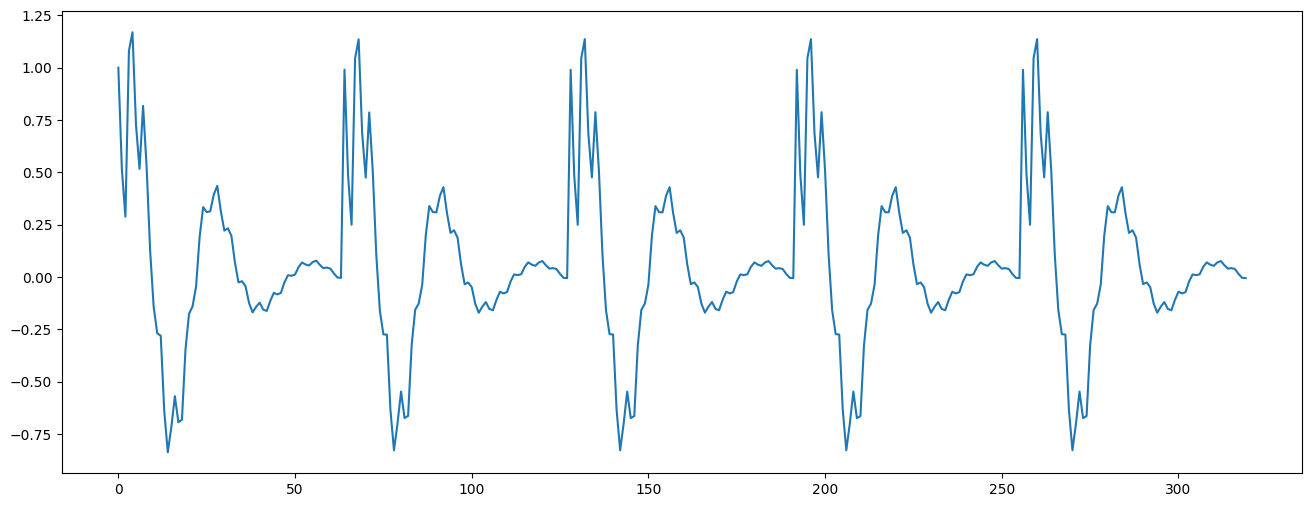

In [164]:
# insert your code here
plt.plot(s1)

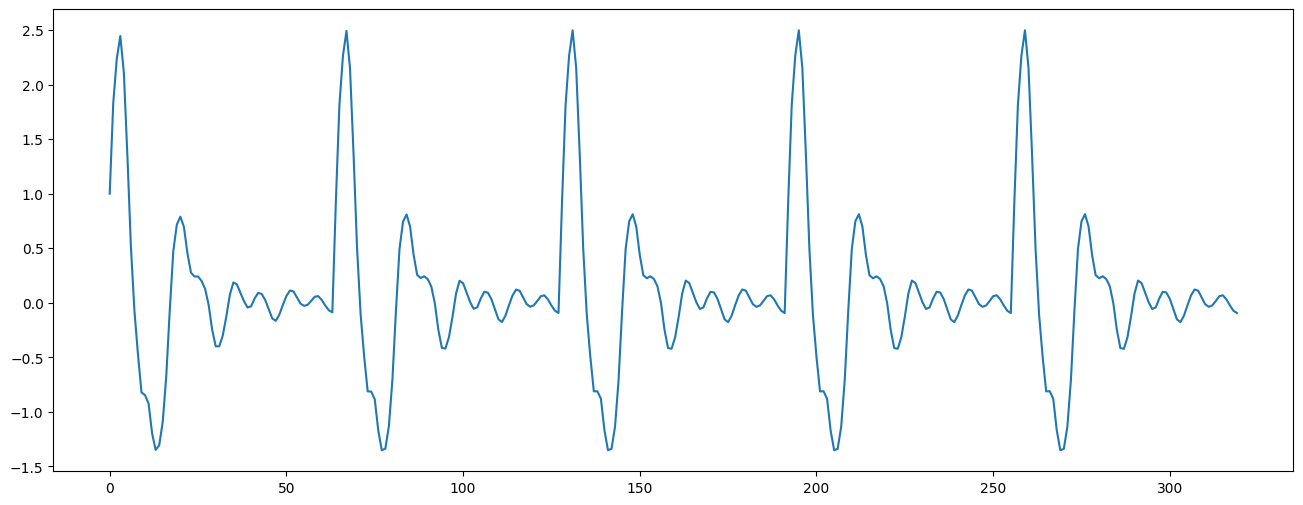

In [165]:
plt.plot(s2)

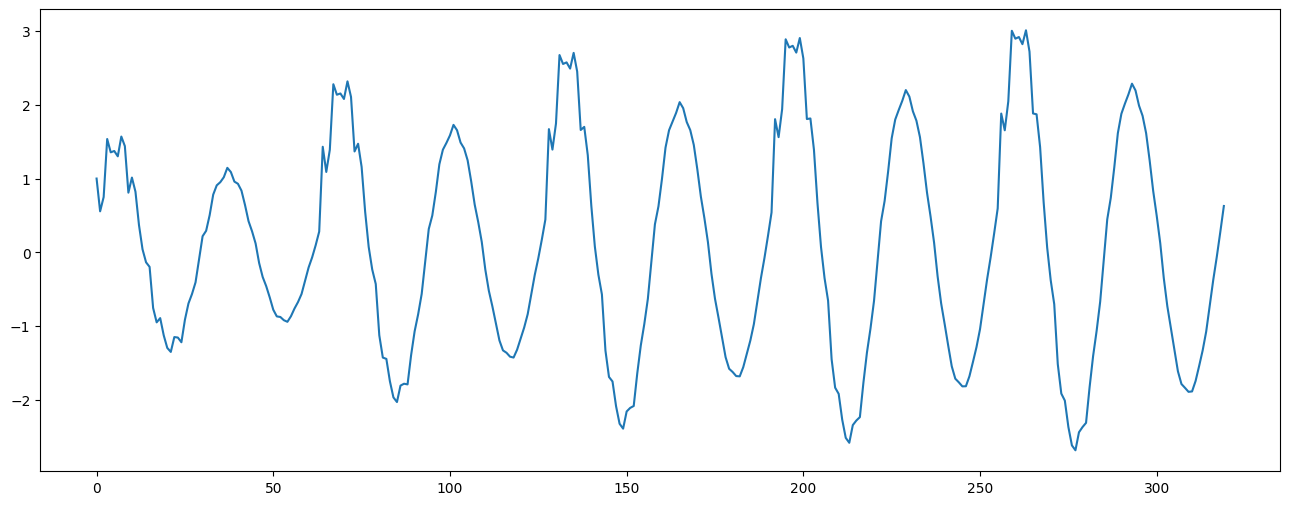

In [166]:
plt.plot(s3)

**5. Use the following command to obtain the frequency response of these filters.**
```python
w, h = scp.signal.freqz(np.array([1]), np.insert(-A, 0, 1), 512)
```
**where `A` is the vector of coefficients.**

In [167]:
# insert your code here
w1, h1 = scp.signal.freqz(np.array([1]), np.insert(-A1, 0, 1), 512)
w2, h2 = scp.signal.freqz(np.array([1]), np.insert(-A2, 0, 1), 512)
w3, h3 = scp.signal.freqz(np.array([1]), np.insert(-A3, 0, 1), 512)

**6. Plot the magnitude of each response versus frequency in Hertz. Make sure to label the frequency axis in units of Hertz.**

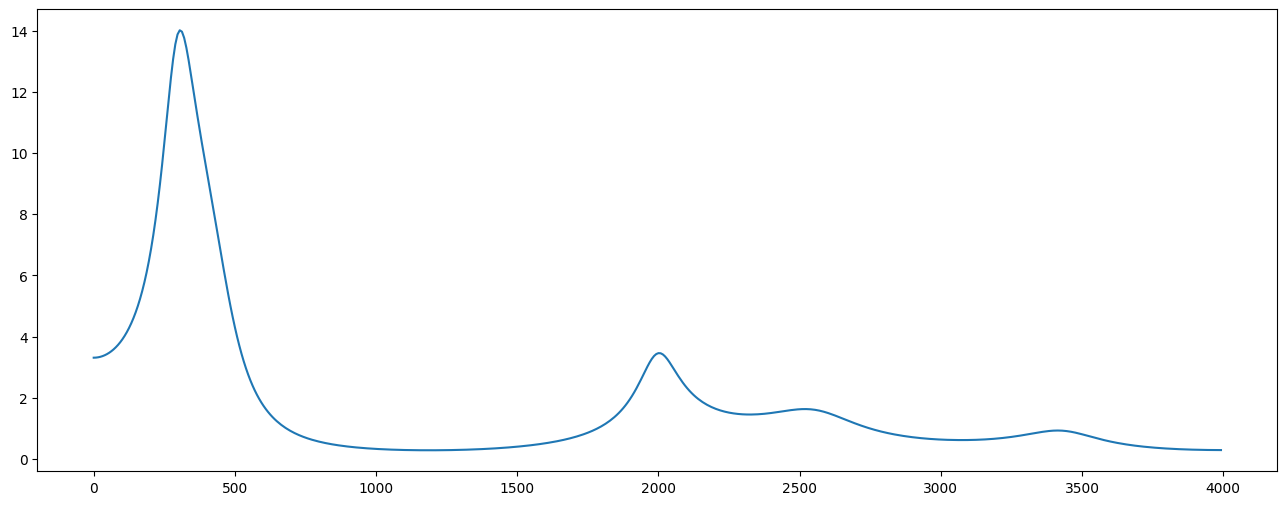

In [168]:
# insert your code here
plt.plot(8000/(2*np.pi)*w1, np.abs(h1))

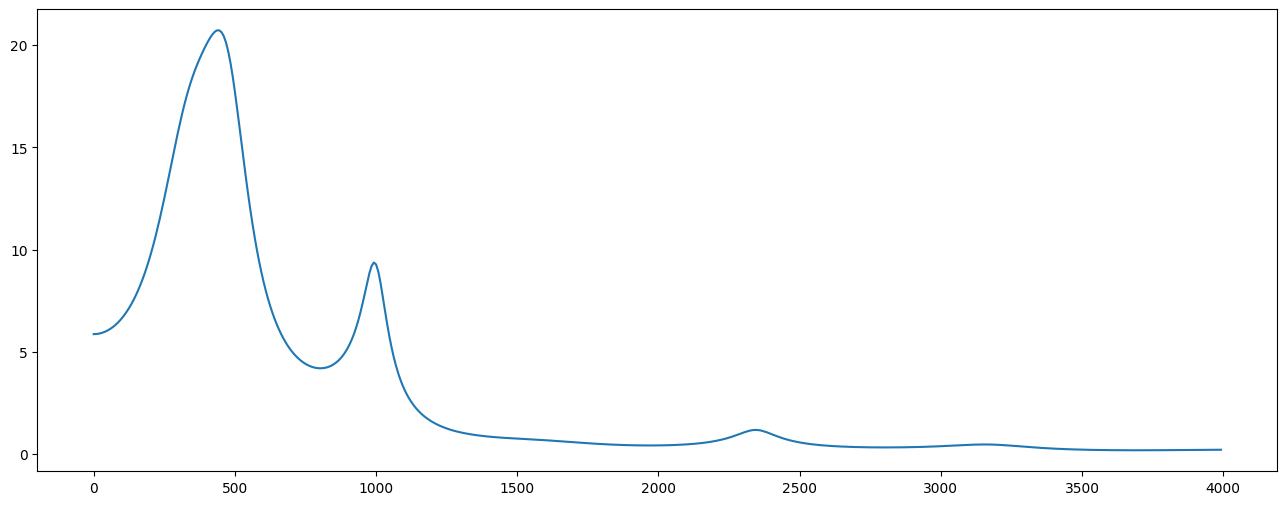

In [169]:
plt.plot(8000/(2*np.pi)*w2, np.abs(h2))

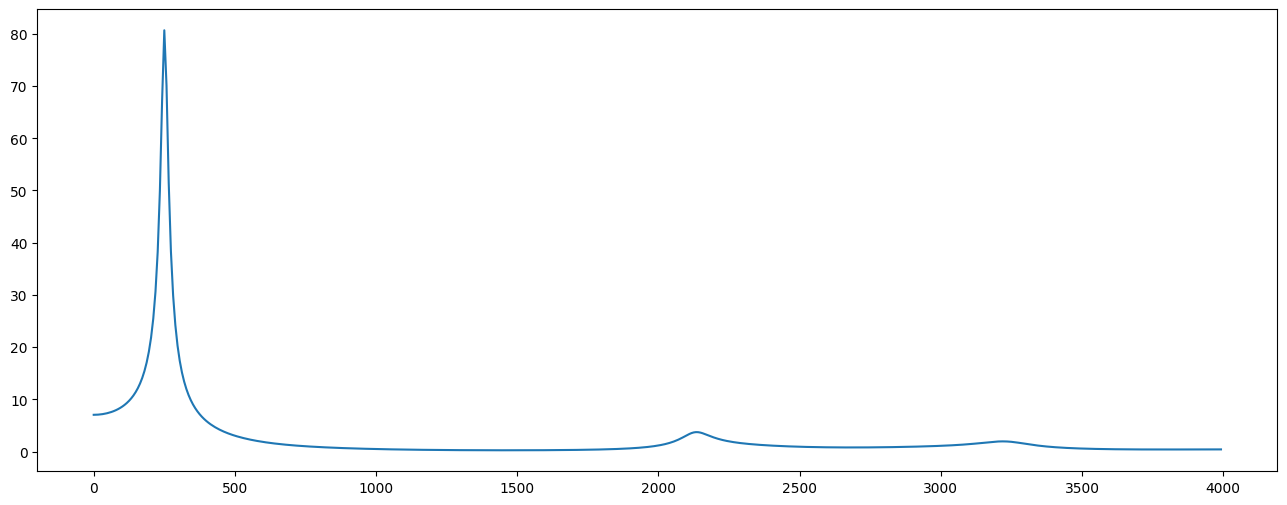

In [170]:
plt.plot(8000/(2*np.pi)*w3, np.abs(h3))

**7. The location of the peaks in the spectrum correspond to the formant frequencies. For each vowel signal, estimate the first three formants (in Hz) and list them.**

insert your answer here

**8. Generate the three signals again, but use an excitation which is 1-2 seconds long. Listen to the filtered signals.**

In [171]:
# insert your code here
x = exciteV(2000, 8)
s1 = scp.signal.lfilter(np.array([1]), np.insert(-A1, 0, 1), x)
s2 = scp.signal.lfilter(np.array([1]), np.insert(-A2, 0, 1), x)
s3 = scp.signal.lfilter(np.array([1]), np.insert(-A3, 0, 1), x)

In [172]:
ipd.Audio(s1, rate = 8000)

In [173]:
ipd.Audio(s2, rate = 8000)

In [174]:
ipd.Audio(s3, rate = 8000)

**9. Can you hear qualitative differences in the signals generated in Q8? Can you identify the vowel sounds?**

insert your answer here

<h3 style="color:red;"><left>Exercise 2.3: LPC</left></h3>

**1. Complete the function below to compute the order-$P$ LPC coefficients for the vector $x$, using the autocorrelation method. Consider the input vector ```x``` as a speech segment, in other words do not divide it up into pieces. The output vector ```coef``` should be a vector containing the ```P``` coefficients $\{\hat{a}_1, \hat{a}_2,\dots,\hat{a}_P\}$. In your function you should do the following:**

* Compute the biased autocorrelation estimate of equation (17) for the lag values $0\leq m \leq P$.
* Form the $\mathbf{r}_S$ and $\mathbf{R}_S$ vectors as in (15) and (16). Hint: Use the [`scp.linalg.toeplitz()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.toeplitz.html) function to form $\mathbf{R}_S$.
* Solve the matrix equation (14) for $\hat{\mathbf{a}}$, which can be solved by inverting the matrix $\mathbf{R}_S$ using [`np.linalg.inv()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html).

In [175]:
def mylpc(x, P):
    """
    Parameters
    ---
    x: the speech segment
    P: the order
    
    Returns
    ---
    coef: the order-P LPC coefficients for x
    """
    r_cap = np.zeros(P+1)
    N = len(x)
    for m in range(P+1):
      for n in range(N - m):
        r_cap[m] += x[n]*x[n+m]
      r_cap[m] /= (1/N)
      
    rs = r_cap[1:(P+1)]
    Rs = scipy.linalg.toeplitz(r_cap[0:P])
    inv_Rs = np.linalg.inv(Rs)
    a_cap = inv_Rs @ rs
  
    return a_cap

**2. Load ```test.json``` using the code below. This file contains two vectors: a signal ```x``` and its order-15 LPC coefficients ```a```. Use your function to compute the order-$15$ LPC coefficients of ```x```, and compare the result to the vector ```a```.**

**Note:** To check if two vectors are close, use the command below. This function will raise error if the two arrays are not equal up to desired tolerance. In the case below, both the absolute tolerance and the relative tolerance are $10^{-10}$.
```python
np.testing.assert_allclose(np.array(coef), np.array(a), atol=1e-10, rtol=1e-10)
```

In [176]:
test = json.load(open("test.json", 'r'))
x = np.array(test['x'])
a = np.array(test['a'])

print(a)

[ 0.51521099  0.02289244  0.92088278  0.13270476 -0.23130043 -0.79304343
 -0.20397227 -0.14077621  0.52269631  0.04471782  0.12478248 -0.04644767
 -0.06510713 -0.06699434 -0.0288174 ]


In [177]:
# insert your code here
coef = mylpc(x, 15)
print(coef)

[ 0.51521099  0.02289244  0.92088278  0.13270476 -0.23130043 -0.79304343
 -0.20397227 -0.14077621  0.52269631  0.04471782  0.12478248 -0.04644767
 -0.06510713 -0.06699434 -0.0288174 ]


<h3 style="color:red;"><left>Exercise 3.1</left></h3>

**1. Load and play the audio file ```phrase.au```. This speeech signal is sampled at a rate of $8000$ Hz.**

In [178]:
# insert your code here
phrase, fs = sf.read("phrase.au")
ipd.Audio(phrase, rate = fs)

**2. Divide the original speech signal into $30$ms non-overlapping frames. Place the frames into $L$ consecutive rows of a matrix $S$ (use [`np.reshape()`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)). If the samples at the tail end of the signal do not fill an entire column, you may disregard these samples.**

**Hint:** Say the original signal is of length `N`, and only the first `M` (is divisible by 10 and is as large as possible) samples are needed, we can calculate `M` easily by
```python
M = N // 10 * 10
```
where `//` is the floor division operator in Python.

In [214]:
# insert your code here
M = len(phrase) // (30*8) * (30*8) # 30 ms times 8 Khz [=] samples
CL = 30 * 8 # column length
RL = int(M/CL) # row length

S = [[0]] * RL
for i in range(RL):
  S[i] = phrase[240*i:240*(i+1)]
S = np.array(S)

**3. For each frame of the original word (i.e., each row of ```S```), do the following:**
* Compute the energy of each frame of the original word, and place these values in a length $L$ vector called ```energy```.
* Determine whether each frame is voiced or unvoiced. Use your zero cross function from the first week to compute the number of zero-crossings in each frame. For length $N$ segments with less than $\frac{N}{2}$ zero-crossings, classify the segment as voiced, otherwise unvoiced. Save the results in a vector ```VU``` which takes the value of `1` for voiced and `0` for unvoiced.
* Use your ```mylpc(x, P)``` function to compute order-$15$ LPC coefficients for each frame. Place each set of coefficients into a column of a $L \times 15$ matrix ```A```.

In [204]:
def get_average_energy(x):
    L = len(x)
    P = (1/L) * np.sum(x**2)
    return P

In [203]:
def get_zero_cross(x):
    sign = ((x[:-1] * x[1:]) < 0)
    cnt = np.sum(sign)
    return cnt

In [220]:
# insert your code here
energy = np.zeros(RL)
for i in range(RL):
  energy[i] = get_average_energy(S[i])

zeros = np.zeros(RL)
voice = np.zeros(RL)
for i in range(RL):
  zeros[i] = get_zero_cross(S[i])
  if zeros[i] < CL/2:
    voice[i] = 1
  else:
    voice[i] = 0

coeff = [[0]] * RL
for i in range(RL):
  coeff[i] = mylpc(S[i], 15)
coeff = np.array(coeff)



10088


**4. To see the reduction in data, add up the total number of bytes Python uses to store the encoded speech in the arrays `A`, `VU`, and `energy` (use the ```sys.getsizeof()``` function). Compute the compression ratio by dividing this by the number of bytes Python uses to store the original speech signal. Note that the compression ratio can be further improved by using a technique called vector quantization on the LPC coefficients, and also by using fewer bits to represent the gain and voiced/unvoiced indicator.**

In [181]:
# insert your code here


**5. Now the computed parameters will be used to re-synthesize the phrase using the model in Figure 1. Similar to your ```exciteV()``` function from [Section 1.2](#Exercise-1.2:-Synthesis-of-Voiced-Speech), complete the function below that returns a length $N$ excitation for unvoiced speech (generate a ```np.random.normal(0, 1)``` sequence).**

In [182]:
def exciteUV(N):
    """
    Parameters
    ---
    N: the length of excitation
    
    Returns
    ---
    x: the excitation of length N
    """
    
    x = None
    return x

**6. Initialize an empty NumPy array `output`. Then, for each encoded frame, do the following:**
* **Check if current frame is voiced or unvoiced.**
* **Generate the frame of speech by using the appropriate excitation into the filter specified by the LPC coefficients (you did this in [Section 1.2](#Exercise-1.2:-Synthesis-of-Voiced-Speech)). For voiced speech, use a pitch period of $7.5$ ms. Make sure your synthesized segment is the same length as the original frame.**
* **Scale the amplitude of the segment so that the synthesized segment has the same energy as the original.**
* **Append `frame` to the end of the `output` array by using `output = np.append(output, frame)`.**

In [183]:
# insert your code here


**7. Plot both the original and synthesizsed words.**

In [184]:
# insert your code here


**8. Listen to the original and synthesized phrase. Comment on the quality of your synthesized signal. How might the quality be improved?**

In [185]:
# insert your code here
